In [1]:
import pandas as pd
import numpy as np

import tubesml as tml

from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, log_loss
from sklearn.linear_model import LogisticRegression

import xgboost as xgb

from source.validate import random_split, yearly_split
from source.report import report_points, report_victory, yearly_wrapper

from source.train_funcs import train_model
from source.report import _point_to_proba
from source.validate import _make_preds

In [2]:
kfolds = KFold(n_splits=7, shuffle=True, random_state=23)

In [3]:
df = pd.read_csv('data/processed_women/training_data.csv')

df['seed_round1'] = 0
df['seed_round2'] = 0

df.loc[(df.T1_Seed < 5) & (df.stage_Round1 == 1), 'seed_round1'] = 1
df.loc[(df.T1_Seed < 2) & (df.stage_Round2 == 1), 'seed_round2'] = 1

df['off_edge_Seed'] = df['delta_Seed'] * df['delta_off_edge']
df['def_edge_Seed'] = df['delta_Seed'] * df['delta_def_edge']

df['T1_DR_edge'] = df['T1_DR_opportunity'] - df['T2_OR_opportunity']
df['T2_DR_edge'] = df['T2_DR_opportunity'] - df['T1_OR_opportunity']
df['delta_DR_edge'] = df['T1_DR_edge'] - df['T2_DR_edge']

df['T1_OR_edge'] = df['T1_OR_opportunity'] - df['T2_DR_opportunity']
df['T2_OR_edge'] = df['T2_OR_opportunity'] - df['T1_DR_opportunity']
df['delta_OR_edge'] = df['T1_OR_edge'] - df['T2_OR_edge']

train_df = df.copy()

train_df.head()

,Season,DayNum,Team1,Team2,target,target_points,T1_Loc,T2_Loc,ID,T1_Ast,...,seed_round1,seed_round2,off_edge_Seed,def_edge_Seed,T1_DR_edge,T2_DR_edge,delta_DR_edge,T1_OR_edge,T2_OR_edge,delta_OR_edge
0,2010,138,3124,3201,1,14,0,0,2010_3124_3201,14.687500,...,1,0,-139.557216,-198.297310,0.361078,0.316318,0.044760,-0.316318,-0.361078,0.044760
1,2010,138,3173,3395,1,1,0,0,2010_3173_3395,14.461538,...,0,0,-15.091164,-16.370410,0.394133,0.273866,0.120267,-0.273866,-0.394133,0.120267
2,2010,138,3181,3214,1,35,1,-1,2010_3181_3214,14.250000,...,1,0,-237.910945,-188.939757,0.357474,0.265349,0.092125,-0.265349,-0.357474,0.092125
3,2010,138,3199,3256,1,14,1,-1,2010_3199_3256,15.333333,...,1,0,-178.484610,-177.421684,0.307223,0.308977,-0.001754,-0.308977,-0.307223,-0.001754
4,2010,138,3207,3265,1,20,0,0,2010_3207_3265,15.866667,...,0,0,-80.862538,-122.529105,0.347945,0.257592,0.090353,-0.257592,-0.347945,0.090353


In [4]:
df = pd.read_csv('data/processed_women/2021_test_data.csv')
df.loc[:,'ID'] = df.Season.astype(str) + '_' + df.Team1.astype(str) + '_' + df.Team2.astype(str)

df['seed_round1'] = 0
df['seed_round2'] = 0

df.loc[(df.T1_Seed < 5) & (df.stage_Round1 == 1), 'seed_round1'] = 1
df.loc[(df.T1_Seed < 2) & (df.stage_Round2 == 1), 'seed_round2'] = 1

df['off_edge_Seed'] = df['delta_Seed'] * df['delta_off_edge']
df['def_edge_Seed'] = df['delta_Seed'] * df['delta_def_edge']

df['T1_DR_edge'] = df['T1_DR_opportunity'] - df['T2_OR_opportunity']
df['T2_DR_edge'] = df['T2_DR_opportunity'] - df['T1_OR_opportunity']
df['delta_DR_edge'] = df['T1_DR_edge'] - df['T2_DR_edge']

df['T1_OR_edge'] = df['T1_OR_opportunity'] - df['T2_DR_opportunity']
df['T2_OR_edge'] = df['T2_OR_opportunity'] - df['T1_DR_opportunity']
df['delta_OR_edge'] = df['T1_OR_edge'] - df['T2_OR_edge']

test_df = df.copy()

test_df.head()

,Team1,Team2,Pred,Season,T1_Ast,T1_Ast_diff,T1_Away,T1_Blk,T1_Blk_diff,T1_DR,...,seed_round1,seed_round2,off_edge_Seed,def_edge_Seed,T1_DR_edge,T2_DR_edge,delta_DR_edge,T1_OR_edge,T2_OR_edge,delta_OR_edge
0,3104,3112,0.5,2021,14.96,1.12,0.36,2.4,-0.96,24.96,...,0,0,100.459072,-11.208990,0.427744,0.434252,-0.006508,-0.434252,-0.427744,-0.006508
1,3104,3116,0.5,2021,14.96,1.12,0.36,2.4,-0.96,24.96,...,0,0,22.269370,31.613236,0.506322,0.378227,0.128094,-0.378227,-0.506322,0.128094
2,3104,3124,0.5,2021,14.96,1.12,0.36,2.4,-0.96,24.96,...,0,0,158.191090,52.595798,0.232570,0.463635,-0.231064,-0.463635,-0.232570,-0.231064
3,3104,3125,0.5,2021,14.96,1.12,0.36,2.4,-0.96,24.96,...,0,0,-91.470825,-36.131838,0.359068,0.380749,-0.021681,-0.380749,-0.359068,-0.021681
4,3104,3133,0.5,2021,14.96,1.12,0.36,2.4,-0.96,24.96,...,0,0,-44.606516,-9.179722,0.422993,0.461486,-0.038494,-0.461486,-0.422993,-0.038494


In [5]:
to_use = ['ID', 'target', 'Season', 'target_points']

d_car = []
t_car = ['Score', 'opp_score', 'FGM_perc', 'Seed', 'Stl', 
         'Blk', 'Ast', 'off_rating', 'def_rating', 'TO', 'Away']
l2wd_car = []
l2wt_car = []

for c in d_car:
    to_use += [f'delta_{c}'] # f'T1_{c}', f'T2_{c}', 
    
for c in t_car:
    to_use += [f'T1_{c}', f'T2_{c}']
    
for c in l2wd_car:
    to_use += [f'delta_L2W_{c}'] # f'T1_{c}', f'T2_{c}', 
    
for c in l2wt_car:
    to_use += [f'T1_L2W_{c}', f'T2_L2W_{c}']
    
to_use += ['seed_round1', 'off_edge_Seed', 'def_edge_Seed']

to_use_xgb = to_use

to_use_xgb

['ID',
 'target',
 'Season',
 'target_points',
 'T1_Score',
 'T2_Score',
 'T1_opp_score',
 'T2_opp_score',
 'T1_FGM_perc',
 'T2_FGM_perc',
 'T1_Seed',
 'T2_Seed',
 'T1_Stl',
 'T2_Stl',
 'T1_Blk',
 'T2_Blk',
 'T1_Ast',
 'T2_Ast',
 'T1_off_rating',
 'T2_off_rating',
 'T1_def_rating',
 'T2_def_rating',
 'T1_TO',
 'T2_TO',
 'T1_Away',
 'T2_Away',
 'seed_round1',
 'off_edge_Seed',
 'def_edge_Seed']

In [6]:
to_use = ['ID', 'target', 'Season']

d_car = ['Score', 'opp_score', 'Blk', 'Stl',
         'def_rating', 'possessions']
t_car = []
l2wd_car = []
l2wt_car = []

for c in d_car:
    to_use += [f'delta_{c}'] # f'T1_{c}', f'T2_{c}', 
    
for c in t_car:
    to_use += [f'T1_{c}', f'T2_{c}']
    
for c in l2wd_car:
    to_use += [f'delta_L2W_{c}'] # f'T1_{c}', f'T2_{c}', 
    
for c in t_car:
    to_use += [f'T1_L2W_{c}', f'T2_L2W_{c}']
    

to_use += ['seed_round1', 'seed_round2', 'off_edge_Seed', 'def_edge_Seed']

to_use_logit = to_use

to_use_logit

['ID',
 'target',
 'Season',
 'delta_Score',
 'delta_opp_score',
 'delta_Blk',
 'delta_Stl',
 'delta_def_rating',
 'delta_possessions',
 'seed_round1',
 'seed_round2',
 'off_edge_Seed',
 'def_edge_Seed']

# Logit Training

In [7]:
logit_target = train_df['target']
logit_index = train_df[['ID', 'Team1', 'Team2', 'target', 'Season']].copy()
logit_train = train_df[[col for col in to_use_logit if col not in ['ID', 'Team1', 'Team2', 'target', 'Season']]].copy()
logit_train.head()

,delta_Score,delta_opp_score,delta_Blk,delta_Stl,delta_def_rating,delta_possessions,seed_round1,seed_round2,off_edge_Seed,def_edge_Seed
0,-1.360795,-3.732008,4.643939,-3.425189,-4.065292,0.432765,1,0,-139.557216,-198.297310
1,-1.530769,-0.800000,0.476923,-2.102564,-0.424508,-0.581346,0,0,-15.091164,-16.370410
2,8.760417,-0.070833,3.047917,3.275000,-2.671770,3.851719,1,0,-237.910945,-188.939757
3,0.208602,-4.222581,0.291398,1.736559,-2.345643,-1.711667,1,0,-178.484610,-177.421684
4,-0.148485,0.457576,-1.884848,5.487879,-2.361552,2.631364,0,0,-80.862538,-122.529105


In [8]:
logit_res = test_df[['ID', 'Team1', 'Team2', 'Season']].copy()
logit_test = test_df[[col for col in to_use_logit if col not in ['ID', 'Team1', 'Team2', 'target', 'Season']]].copy()
logit_test.head()

,delta_Score,delta_opp_score,delta_Blk,delta_Stl,delta_def_rating,delta_possessions,seed_round1,seed_round2,off_edge_Seed,def_edge_Seed
0,8.228571,13.992381,-2.219048,-5.243810,18.010992,1.296952,0,0,100.459072,-11.208990
1,-8.274074,-4.034074,-0.414815,-2.645926,0.319348,-5.353444,0,0,22.269370,31.613236
2,-6.792593,15.558519,-2.488889,-4.164444,24.534443,-3.628444,0,0,158.191090,52.595798
3,4.360000,11.920000,-0.360000,-5.600000,11.190390,4.438000,0,0,-91.470825,-36.131838
4,5.022222,4.854815,-2.488889,-1.201481,4.047854,1.783593,0,0,-44.606516,-9.179722


In [9]:
logit_pipe = Pipeline([('scl', tml.DfScaler(method='robust')),
                 ('logit', LogisticRegression(random_state=23, C=0.04))])

In [10]:
grid_param = {'logit__C': np.arange(1, 20, 0.5), 'scl__method': ['robust','standard']}

res, bp, be = tml.grid_search(logit_train, logit_target, logit_pipe, grid_param, 'neg_log_loss', kfolds)

print(bp)

res

{'logit__C': 10.5, 'scl__method': 'robust'}


,param_logit__C,param_scl__method,mean_train_score,std_train_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time
0,10.5,robust,-0.408294,0.005650,-0.416480,0.034200,0.016617,0.001586,0.003303,0.000118
1,11.5,robust,-0.408206,0.005650,-0.416481,0.034137,0.016862,0.000703,0.003295,0.000115
2,10.0,robust,-0.408344,0.005650,-0.416483,0.034233,0.017052,0.000625,0.003381,0.000221
3,9.5,robust,-0.408400,0.005650,-0.416483,0.034276,0.022895,0.000838,0.003679,0.000391
4,11.0,robust,-0.408248,0.005650,-0.416484,0.034161,0.016808,0.001943,0.003228,0.000127
...,...,...,...,...,...,...,...,...,...,...
71,19.5,standard,-0.407563,0.005621,-0.417957,0.031910,0.015342,0.001610,0.003231,0.000275
72,1.0,standard,-0.411126,0.005549,-0.418104,0.034353,0.012575,0.000936,0.003552,0.000342
73,2.0,robust,-0.411740,0.005681,-0.418215,0.035868,0.015072,0.000922,0.003291,0.000123
74,1.5,robust,-0.412629,0.005709,-0.418840,0.036234,0.015166,0.001108,0.003563,0.000186


In [11]:
logit_pipe = Pipeline([('scl', tml.DfScaler(method='robust')),
                 ('logit', LogisticRegression(random_state=23, C=10.5))])

In [12]:
_, logit_index['oof_pred'], feat_imp, logit_res['logit_pred'] = _make_preds(logit_train, logit_target, logit_test, logit_pipe, kfolds, predict_proba=True)
feat_imp

,mean,std
feat,,
delta_opp_score,-4.326706,0.306282
delta_def_rating,3.370142,0.240762
seed_round1,2.608781,0.205748
seed_round2,2.318799,0.028453
delta_possessions,1.667909,0.167448
delta_Score,1.018037,0.031181
def_edge_Seed,-0.980208,0.021844
off_edge_Seed,-0.846261,0.042499
delta_Blk,0.500036,0.007417


In [13]:
logit_index.head()

,ID,Team1,Team2,target,Season,oof_pred
0,2010_3124_3201,3124,3201,1,2010,0.994878
1,2010_3173_3395,3173,3395,1,2010,0.495418
2,2010_3181_3214,3181,3214,1,2010,0.998585
3,2010_3199_3256,3199,3256,1,2010,0.994222
4,2010_3207_3265,3207,3265,1,2010,0.653024


<AxesSubplot:>

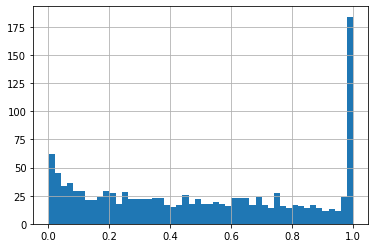

In [14]:
logit_index['oof_pred'].hist(bins=50)

Accuracy train: 		 0.7984
Accuracy test: 			 0.7984
Logloss train: 			 0.4201
Logloss test: 			 0.4201
Unsure train: 			 14.8413%
Unsure test: 			 14.8413%


,acc_oof,acc_test,logloss_oof,logloss_test,unsure_oof,unsure_test
0,0.7984,0.7984,0.4201,0.4201,14.8413,14.8413


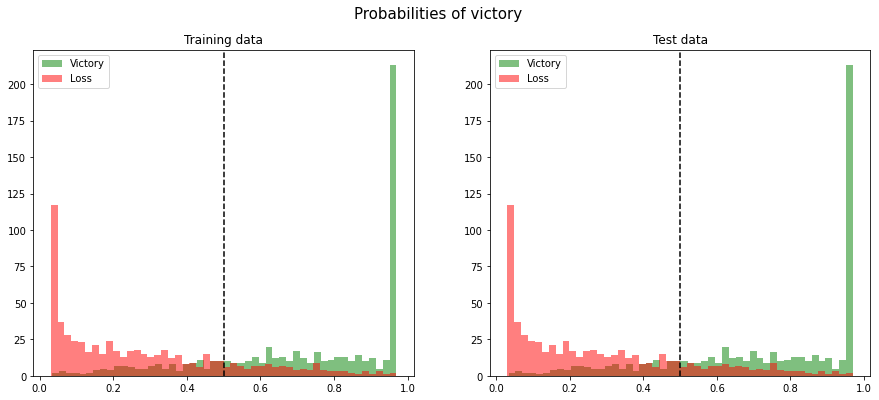

In [15]:
report_victory(logit_target, logit_target, logit_index['oof_pred'], logit_index['oof_pred'], probs=True, plot=True)

In [16]:
logit_res.head()

,ID,Team1,Team2,Season,logit_pred
0,2021_3104_3112,3104,3112,2021,0.301039
1,2021_3104_3116,3104,3116,2021,0.300276
2,2021_3104_3124,3104,3124,2021,0.060146
3,2021_3104_3125,3104,3125,2021,0.483785
4,2021_3104_3133,3104,3133,2021,0.400731


<AxesSubplot:>

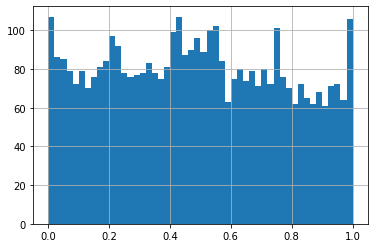

In [17]:
logit_res.logit_pred.hist(bins=50)

# XGB train

In [18]:
def cauchyobj(labels, preds):
    c = 7000 
    x =  preds - labels    
    grad = x / (x**2 / c**2 + 1)
    hess = - c**2 *(x**2 - c**2) / (x**2 + c**2)**2
    return grad, hess

In [19]:
xgb_target = train_df['target_points']
xgb_index = train_df[['ID', 'Team1', 'Team2', 'target_points', 'target', 'Season']].copy()
xgb_train = train_df[[col for col in to_use_xgb if col not in ['ID', 'Team1', 'Team2', 'target', 'target_points', 'Season']]].copy()
xgb_train.head()

,T1_Score,T2_Score,T1_opp_score,T2_opp_score,T1_FGM_perc,T2_FGM_perc,T1_Seed,T2_Seed,T1_Stl,T2_Stl,...,T2_off_rating,T1_def_rating,T2_def_rating,T1_TO,T2_TO,T1_Away,T2_Away,seed_round1,off_edge_Seed,def_edge_Seed
0,72.093750,73.454545,56.843750,60.575758,0.463117,0.419783,4.0,13.0,6.968750,10.393939,...,101.762731,79.729697,83.794988,16.875000,15.636364,0.250000,0.424242,1,-139.557216,-198.297310
1,70.769231,72.300000,59.500000,60.300000,0.420625,0.414882,8.0,9.0,7.730769,9.833333,...,98.150641,81.780231,82.204739,16.961538,16.033333,0.461538,0.233333,0,-15.091164,-16.370410
2,71.593750,62.833333,55.062500,55.133333,0.421078,0.369384,2.0,15.0,13.375000,10.100000,...,90.589453,76.055626,78.727396,17.906250,15.533333,0.312500,0.300000,1,-237.910945,-188.939757
3,74.466667,74.258065,60.100000,64.322581,0.445946,0.434469,3.0,14.0,8.833333,7.096774,...,98.074971,81.945727,84.291370,19.033333,17.096774,0.333333,0.451613,1,-178.484610,-177.421684
4,68.033333,68.181818,58.366667,57.909091,0.395465,0.420566,5.0,12.0,13.366667,7.878788,...,100.914559,83.410401,85.771953,16.300000,13.484848,0.400000,0.242424,0,-80.862538,-122.529105


In [20]:
xgb_index.shape

(1260, 6)

In [22]:
xgb_res = test_df[['ID', 'Team1', 'Team2', 'Season']].copy()
xgb_test = test_df[[col for col in to_use_xgb if col not in ['ID', 'Team1', 'Team2', 'target', 'target_points', 'Season']]].copy()
xgb_test.head()

,T1_Score,T2_Score,T1_opp_score,T2_opp_score,T1_FGM_perc,T2_FGM_perc,T1_Seed,T2_Seed,T1_Stl,T2_Stl,...,T2_off_rating,T1_def_rating,T2_def_rating,T1_TO,T2_TO,T1_Away,T2_Away,seed_round1,off_edge_Seed,def_edge_Seed
0,74.8,66.571429,70.04,56.047619,0.435484,0.407874,7.0,3.0,5.28,10.523810,...,93.643771,96.446019,78.435026,12.96,12.380952,0.36,0.238095,0,100.459072,-11.208990
1,74.8,83.074074,70.04,74.074074,0.435484,0.448336,7.0,4.0,5.28,7.925926,...,106.983764,96.446019,96.126671,12.96,10.259259,0.36,0.259259,0,22.269370,31.613236
2,74.8,81.592593,70.04,54.481481,0.435484,0.486228,7.0,2.0,5.28,9.444444,...,106.965178,96.446019,71.911576,12.96,16.111111,0.36,0.481481,0,158.191090,52.595798
3,74.8,70.440000,70.04,58.120000,0.435484,0.442799,7.0,12.0,5.28,10.880000,...,103.672386,96.446019,85.255629,12.96,13.240000,0.36,0.480000,0,-91.470825,-36.131838
4,74.8,69.777778,70.04,65.185185,0.435484,0.417643,7.0,11.0,5.28,6.481481,...,98.740949,96.446019,92.398165,12.96,12.481481,0.36,0.259259,0,-44.606516,-9.179722


In [23]:
proc_pipe = Pipeline([('scl', tml.DfImputer())])
# estimator = xgb.XGBRegressor(learning_rate=0.01, n_estimators=2000, objective=cauchyobj, max_depth=3,
#                                            n_jobs=5, subsample=0.5, reg_alpha=0, reg_lambda=10, colsample_bytree=0.7)
estimator = xgb.XGBRegressor(learning_rate=0.01, n_estimators=4000, objective=cauchyobj, max_depth=48,
                                           n_jobs=5, subsample=0.12, reg_alpha=0.02, reg_lambda=0, colsample_bytree=0.86)


xgb_index['oof_pointpred'], xgb_res['xgb_pointpred'], rep_res = train_model(xgb_train, xgb_test, xgb_target,
                                                                       proc_pipe, estimator, kfolds, early_stopping=200, eval_metric='mae')

In [24]:
rep_res['n_iterations']

[399, 594, 206, 221, 285, 503, 392]

In [25]:
rep_res['feat_imp']

,mean,std
feat,,
def_edge_Seed,0.152002,0.005029
seed_round1,0.127221,0.031450
off_edge_Seed,0.126292,0.004973
T1_off_rating,0.039133,0.002038
T2_off_rating,0.038761,0.002150
T2_Seed,0.036328,0.001586
T2_Ast,0.035254,0.002110
T1_def_rating,0.034145,0.001684
T1_Ast,0.034137,0.001583


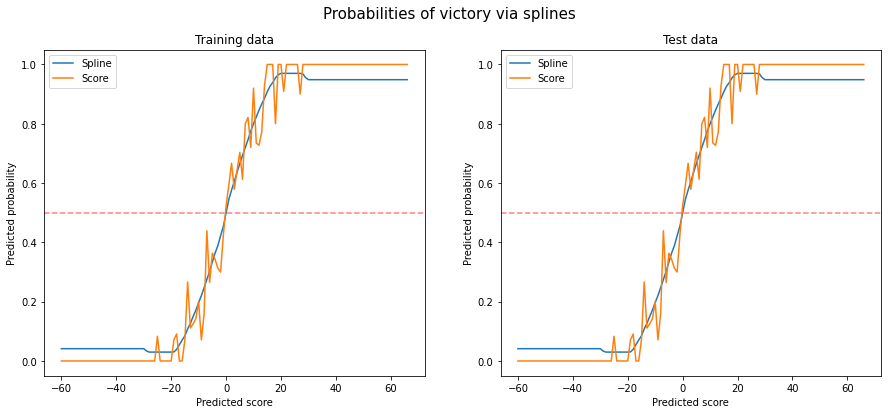

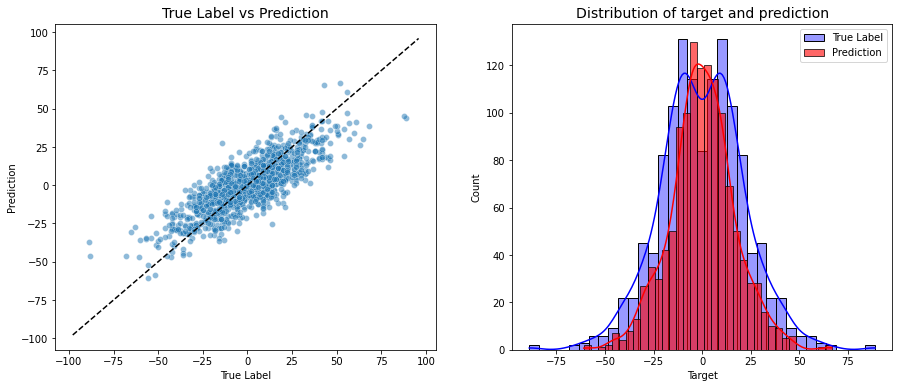

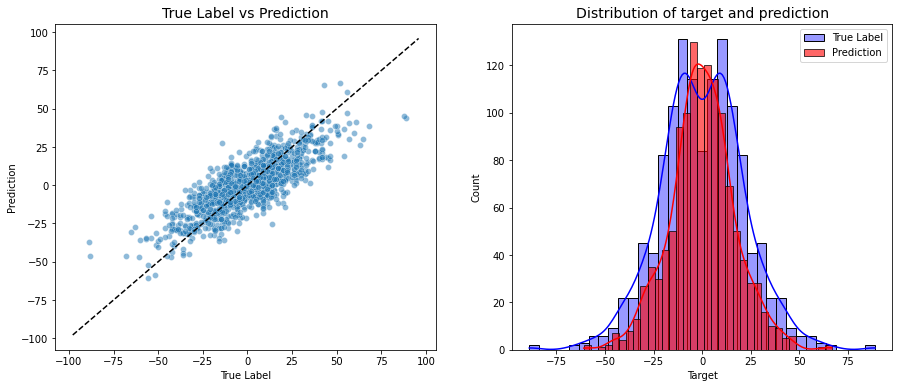

MAE train: 			 10.175
MAE test: 			 10.175
RMSE train: 			 12.766
RMSE test: 			 12.766
Accuracy train: 		 0.7905
Accuracy test: 			 0.7905
Logloss train: 			 0.4383
Logloss test: 			 0.4383
Unsure train: 			 9.52%
Unsure test: 			 9.52%


,mae_oof,mae_test,mse_oof,mse_test,acc_oof,acc_test,logloss_oof,logloss_test,unsure_oof,unsure_test
0,10.175,10.175,12.766,12.766,0.7905,0.7905,0.4383,0.4383,9.52,9.52


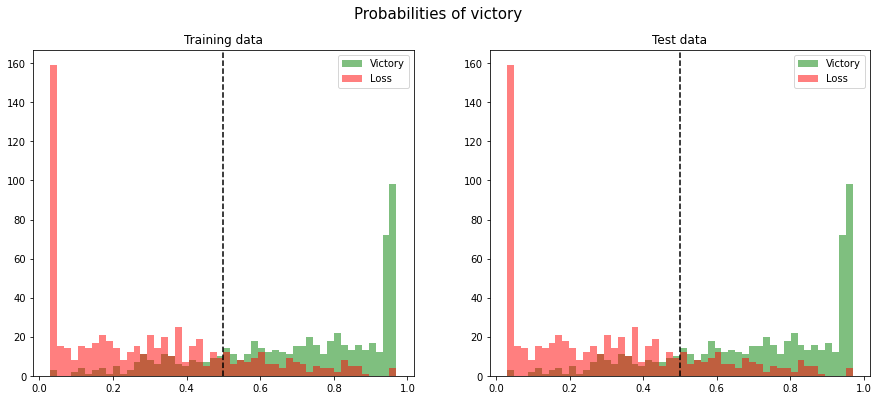

In [26]:
report_points(xgb_train, xgb_train, xgb_target, xgb_target, xgb_index['oof_pointpred'], xgb_index['oof_pointpred'], plot=True)

In [27]:
xgb_index['oof_pred'], xgb_res['xgb_pred'] = _point_to_proba(xgb_index['oof_pointpred'], xgb_index['target'], xgb_res['xgb_pointpred'])

In [28]:
xgb_res.head()

,ID,Team1,Team2,Season,xgb_pointpred,xgb_pred
0,2021_3104_3112,3104,3112,2021,-5.260330,0.339919
1,2021_3104_3116,3104,3116,2021,-5.703027,0.327050
2,2021_3104_3124,3104,3124,2021,-21.125140,0.030000
3,2021_3104_3125,3104,3125,2021,-0.349561,0.487689
4,2021_3104_3133,3104,3133,2021,-0.475886,0.483827


<AxesSubplot:>

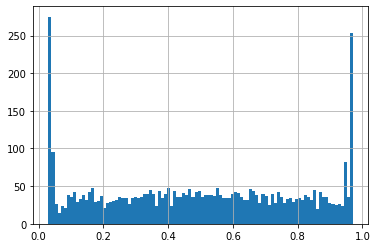

In [29]:
xgb_res['xgb_pred'].hist(bins=100)

# Combining

Accord: 	0.9349206349206349
Logit: 		0.4164802975599529
Xgb: 		0.43832337270639254
Mean: 		0.42158716831366994
Boost sure: 	0.42734585668478625
Boost sure+mean: 0.42792107593116574
No uncertain: 0.4476033592550234
Accuracy train: 		 0.7984
Accuracy test: 			 0.7968
Logloss train: 			 0.4273
Logloss test: 			 0.4228
Unsure train: 			 14.8413%
Unsure test: 			 17.3016%


,ID,Team1,Team2,target,Season,logit_pred,target_points,oof_pointpred,xgb_pred,mean_pred,accord_win,accord_loss,accord,boostsure,avg_boost,no_uncertain
0,2010_3124_3201,3124,3201,1,2010,0.994878,14,15.696978,0.911048,0.952963,1,0,1,0.970000,0.970000,0.970000
1,2010_3173_3395,3173,3395,1,2010,0.495418,1,2.954018,0.588235,0.541827,0,0,0,0.495418,0.495418,0.495418
2,2010_3181_3214,3181,3214,1,2010,0.998585,35,33.428661,0.948693,0.973639,1,0,1,0.970000,0.970000,0.970000
3,2010_3199_3256,3199,3256,1,2010,0.994222,14,17.382153,0.938600,0.966411,1,0,1,0.970000,0.970000,0.970000
4,2010_3207_3265,3207,3265,1,2010,0.653024,20,4.857635,0.644866,0.648945,1,0,1,0.653024,0.648945,0.753024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,2019_3234_3124,3234,3124,0,2019,0.180487,-32,-14.540144,0.105780,0.143133,0,1,1,0.030487,0.030487,0.030487
1256,2019_3390_3323,3390,3323,0,2019,0.192997,-16,-10.997904,0.184477,0.188737,0,1,1,0.042997,0.042997,0.042997
1257,2019_3332_3124,3332,3124,0,2019,0.342356,-5,-7.850898,0.266389,0.304372,0,1,1,0.342356,0.304372,0.242356
1258,2019_3323_3163,3323,3163,1,2019,0.666059,5,2.603669,0.577669,0.621864,1,0,1,0.666059,0.621864,0.766059


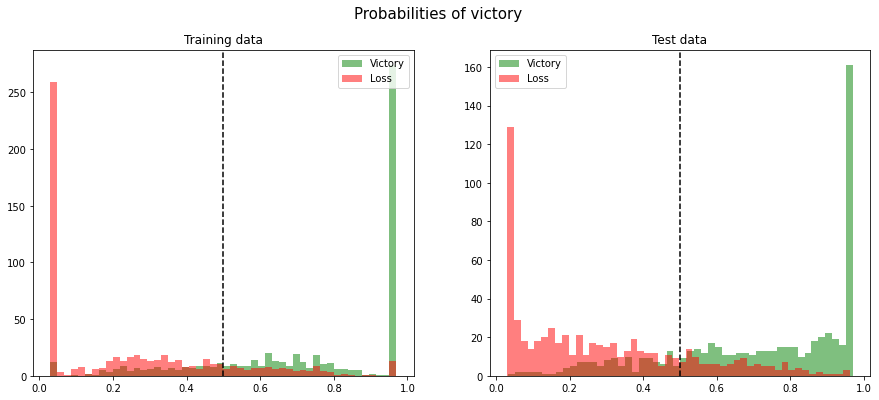

In [30]:
logit_index.rename(columns={'oof_pred': 'logit_pred'}, inplace=True)
xgb_index.rename(columns={'oof_pred': 'xgb_pred'}, inplace=True)

all_pred = pd.merge(logit_index, xgb_index, on=['ID', 'Team1', 'Team2', 'Season', 'target'])
lim = 0.3
all_pred['mean_pred'] = (all_pred['logit_pred'] + all_pred['xgb_pred']) / 2

all_pred['accord_win'] = np.where((all_pred['logit_pred'] > 0.50) & (all_pred['xgb_pred'] > 0.50), 1, 0)
all_pred['accord_loss'] = np.where((all_pred['logit_pred'] < 0.50) & (all_pred['xgb_pred'] < 0.50), 1, 0)
all_pred['accord'] = np.where(all_pred['accord_win'] + all_pred['accord_loss'] > 0, 1, 0)

all_pred['boostsure'] = all_pred.logit_pred

all_pred.loc[((all_pred.logit_pred > 0.5+lim) & (all_pred.xgb_pred > 0.5+lim)), 'boostsure'] = all_pred['boostsure'] + 0.15
all_pred.loc[((all_pred.logit_pred < 0.5-lim) & (all_pred.xgb_pred < 0.5-lim)), 'boostsure'] = all_pred['boostsure'] - 0.15
all_pred['boostsure'] = np.clip(all_pred['boostsure'], 0.03, 0.97)

all_pred['avg_boost'] = all_pred.boostsure

all_pred.loc[((all_pred.logit_pred > 0.5) & (all_pred.xgb_pred > 0.5) & 
              (all_pred.logit_pred < 0.5+lim) & (all_pred.xgb_pred < 0.5+lim)), 'avg_boost'] = all_pred['mean_pred']
all_pred.loc[((all_pred.logit_pred < 0.5) & (all_pred.xgb_pred < 0.5) & 
              (all_pred.logit_pred > 0.5-lim) & (all_pred.xgb_pred > 0.5-lim)), 'avg_boost'] = all_pred['mean_pred']
all_pred['avg_boost'] = np.clip(all_pred['avg_boost'], 0.03, 0.97)

all_pred['no_uncertain'] = all_pred.boostsure

all_pred.loc[((all_pred.logit_pred > 0.5) & (all_pred.xgb_pred > 0.5) & 
              ((all_pred.logit_pred < 0.5+lim) | (all_pred.xgb_pred < 0.5+lim))), 'no_uncertain'] = all_pred['no_uncertain'] + 0.1
all_pred.loc[((all_pred.logit_pred < 0.5) & (all_pred.xgb_pred < 0.5) & 
              ((all_pred.logit_pred > 0.5-lim) | (all_pred.xgb_pred > 0.5-lim))), 'no_uncertain'] = all_pred['no_uncertain'] - 0.1
all_pred['no_uncertain'] = np.clip(all_pred['no_uncertain'], 0.03, 0.97)


print(f'Accord: \t{all_pred.accord.mean()}')
print(f'Logit: \t\t{log_loss(y_pred=all_pred.logit_pred, y_true=all_pred.target)}')
print(f'Xgb: \t\t{log_loss(y_pred=all_pred.xgb_pred, y_true=all_pred.target)}')
print(f'Mean: \t\t{log_loss(y_pred=all_pred.mean_pred, y_true=all_pred.target)}')
print(f'Boost sure: \t{log_loss(y_pred=all_pred.boostsure, y_true=all_pred.target)}')
print(f'Boost sure+mean: {log_loss(y_pred=all_pred.avg_boost, y_true=all_pred.target)}')
print(f'No uncertain: {log_loss(y_pred=all_pred.no_uncertain, y_true=all_pred.target)}')
report_victory(all_pred.target, all_pred.target, all_pred.boostsure, all_pred.mean_pred, probs=True, plot=True)
all_pred

In [31]:
all_pred = pd.merge(logit_res, xgb_res, on=['ID', 'Team1', 'Team2', 'Season'])
lim = 0.3
all_pred['mean_pred'] = (all_pred['logit_pred'] + all_pred['xgb_pred']) / 2

all_pred['accord_win'] = np.where((all_pred['logit_pred'] > 0.50) & (all_pred['xgb_pred'] > 0.50), 1, 0)
all_pred['accord_loss'] = np.where((all_pred['logit_pred'] < 0.50) & (all_pred['xgb_pred'] < 0.50), 1, 0)
all_pred['accord'] = np.where(all_pred['accord_win'] + all_pred['accord_loss'] > 0, 1, 0)

all_pred['boostsure'] = all_pred.logit_pred

all_pred.loc[((all_pred.logit_pred > 0.5+lim) & (all_pred.xgb_pred > 0.5+lim)), 'boostsure'] = all_pred['boostsure'] + 0.15
all_pred.loc[((all_pred.logit_pred < 0.5-lim) & (all_pred.xgb_pred < 0.5-lim)), 'boostsure'] = all_pred['boostsure'] - 0.15
all_pred['boostsure'] = np.clip(all_pred['boostsure'], 0.03, 0.97)

all_pred['avg_boost'] = all_pred.boostsure

all_pred.loc[((all_pred.logit_pred > 0.5) & (all_pred.xgb_pred > 0.5) & 
              (all_pred.logit_pred < 0.5+lim) & (all_pred.xgb_pred < 0.5+lim)), 'avg_boost'] = all_pred['mean_pred']
all_pred.loc[((all_pred.logit_pred < 0.5) & (all_pred.xgb_pred < 0.5) & 
              (all_pred.logit_pred > 0.5-lim) & (all_pred.xgb_pred > 0.5-lim)), 'avg_boost'] = all_pred['mean_pred']
all_pred['avg_boost'] = np.clip(all_pred['avg_boost'], 0.03, 0.97)

all_pred['no_uncertain'] = all_pred.boostsure

all_pred.loc[((all_pred.logit_pred > 0.5) & (all_pred.xgb_pred > 0.5) & 
              ((all_pred.logit_pred < 0.5+lim) | (all_pred.xgb_pred < 0.5+lim))), 'no_uncertain'] = all_pred['no_uncertain'] + 0.05
all_pred.loc[((all_pred.logit_pred < 0.5) & (all_pred.xgb_pred < 0.5) & 
              ((all_pred.logit_pred > 0.5-lim) | (all_pred.xgb_pred > 0.5-lim))), 'no_uncertain'] = all_pred['no_uncertain'] - 0.05
all_pred['no_uncertain'] = np.clip(all_pred['no_uncertain'], 0.03, 0.97)

all_pred

,ID,Team1,Team2,Season,logit_pred,xgb_pointpred,xgb_pred,mean_pred,accord_win,accord_loss,accord,boostsure,avg_boost,no_uncertain
0,2021_3104_3112,3104,3112,2021,0.301039,-5.260330,0.339919,0.320479,0,1,1,0.301039,0.320479,0.251039
1,2021_3104_3116,3104,3116,2021,0.300276,-5.703027,0.327050,0.313663,0,1,1,0.300276,0.313663,0.250276
2,2021_3104_3124,3104,3124,2021,0.060146,-21.125140,0.030000,0.045073,0,1,1,0.030000,0.030000,0.030000
3,2021_3104_3125,3104,3125,2021,0.483785,-0.349561,0.487689,0.485737,0,1,1,0.483785,0.485737,0.433785
4,2021_3104_3133,3104,3133,2021,0.400731,-0.475886,0.483827,0.442279,0,1,1,0.400731,0.442279,0.350731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4027,2021_3460_3450,3460,3450,2021,0.227464,-6.719672,0.297941,0.262702,0,1,1,0.227464,0.262702,0.177464
4028,2021_3461_3450,3461,3450,2021,0.342553,-4.208295,0.370906,0.356730,0,1,1,0.342553,0.356730,0.292553
4029,2021_3460_3452,3460,3452,2021,0.125934,-17.137807,0.059701,0.092818,0,1,1,0.030000,0.030000,0.030000
4030,2021_3461_3452,3461,3452,2021,0.232088,-15.252508,0.092066,0.162077,0,1,1,0.232088,0.232088,0.182088


array([[<AxesSubplot:title={'center':'Team1'}>,
        <AxesSubplot:title={'center':'Team2'}>,
        <AxesSubplot:title={'center':'Season'}>,
        <AxesSubplot:title={'center':'logit_pred'}>],
       [<AxesSubplot:title={'center':'xgb_pointpred'}>,
        <AxesSubplot:title={'center':'xgb_pred'}>,
        <AxesSubplot:title={'center':'mean_pred'}>,
        <AxesSubplot:title={'center':'accord_win'}>],
       [<AxesSubplot:title={'center':'accord_loss'}>,
        <AxesSubplot:title={'center':'accord'}>,
        <AxesSubplot:title={'center':'boostsure'}>,
        <AxesSubplot:title={'center':'avg_boost'}>],
       [<AxesSubplot:title={'center':'no_uncertain'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

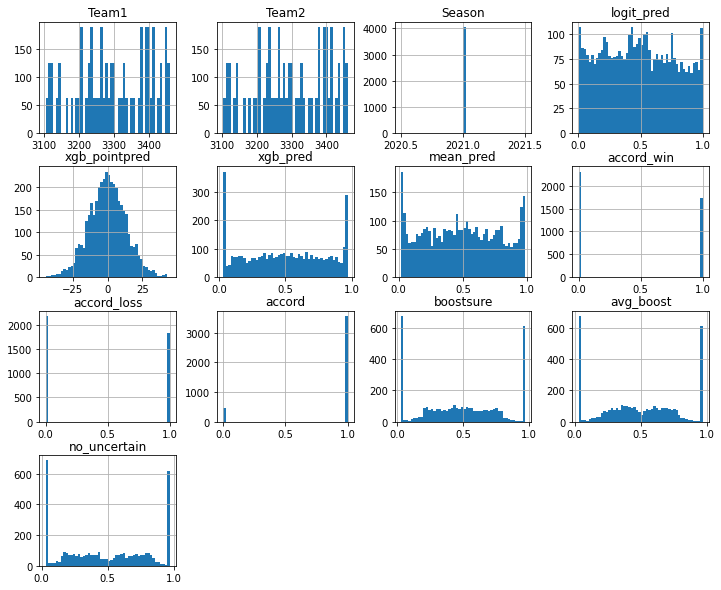

In [32]:
all_pred.hist(bins=50, figsize=(12, 10))


# Spread submission

In [33]:
normal_scores = xgb_res[xgb_res.Team1 < xgb_res.Team2]#[['ID', 'Team1', 'Team2', 'xgb_pred', 'xgb_pointpred']]
opp_scores = xgb_res[xgb_res.Team1 > xgb_res.Team2].copy()#[['ID', 'Team1', 'Team2', 'xgb_pred', 'xgb_pointpred']].copy()
opp_scores.drop(['ID', 'Season'], axis=1, inplace=True)
tot_scores = pd.merge(normal_scores, opp_scores, left_on=['Team1', 'Team2'], right_on=['Team2', 'Team1'])
tot_scores['xgb_preds'] = (tot_scores['xgb_pred_x'] + 1 -  tot_scores['xgb_pred_y']) / 2
tot_scores['Pred'] = round((tot_scores['xgb_pointpred_x'] -  tot_scores['xgb_pointpred_y']) / 2, 0).astype(int)

tot_scores[['ID', 'Pred']].to_csv('oof/2021_women_submission_spread.csv', index=False)

tot_scores.head()

,ID,Team1_x,Team2_x,Season,xgb_pointpred_x,xgb_pred_x,Team1_y,Team2_y,xgb_pointpred_y,xgb_pred_y,xgb_preds,Pred
0,2021_3104_3112,3104,3112,2021,-5.260330,0.339919,3112,3104,4.150386,0.624003,0.357958,-5
1,2021_3104_3116,3104,3116,2021,-5.703027,0.327050,3116,3104,3.807417,0.613805,0.356622,-5
2,2021_3104_3124,3104,3124,2021,-21.125140,0.030000,3124,3104,22.935925,0.970000,0.030000,-22
3,2021_3104_3125,3104,3125,2021,-0.349561,0.487689,3125,3104,-0.361801,0.487315,0.500187,0
4,2021_3104_3133,3104,3133,2021,-0.475886,0.483827,3133,3104,-0.800907,0.473893,0.504967,0


# Main submission

In [34]:
normal_scores = all_pred[all_pred.Team1 < all_pred.Team2]
opp_scores = all_pred[all_pred.Team1 > all_pred.Team2].copy()
opp_scores.drop(['ID', 'Season'], axis=1, inplace=True)
tot_scores = pd.merge(normal_scores, opp_scores, left_on=['Team1', 'Team2'], right_on=['Team2', 'Team1'])
tot_scores['mean_pred'] = (tot_scores['mean_pred_x'] + 1 -  tot_scores['mean_pred_y']) / 2
tot_scores['boostsure'] = (tot_scores['boostsure_x'] + 1 -  tot_scores['boostsure_y']) / 2
tot_scores['avg_boost'] = (tot_scores['avg_boost_x'] + 1 -  tot_scores['avg_boost_y']) / 2

tot_scores.rename(columns={'Team1_x': 'Team1', 'Team2_x': 'Team2'}, inplace=True)

tot_scores = tot_scores[['ID', 'Team1', 'Team2', 'mean_pred', 'boostsure', 'avg_boost']].copy()

tot_scores = pd.merge(tot_scores, 
                      test_df[['Team1', 'Team2', 'T1_Seed', 'T2_Seed'] + [col for col in test_df if 'stage' in col]], 
                      on=['Team1', 'Team2'], how='left')

teams = pd.read_csv('data/raw_women/WDataFiles_Stage2/WTeams.csv')[['TeamID', 'TeamName']]

teams.rename(columns={'TeamID': 'Team1', 'TeamName': 'Name1'}, inplace=True)
tot_scores = pd.merge(tot_scores, teams, on='Team1', how='left')
teams.rename(columns={'Team1': 'Team2', 'Name1': 'Name2'}, inplace=True)
tot_scores = pd.merge(tot_scores, teams, on='Team2', how='left')

tot_scores

,ID,Team1,Team2,mean_pred,boostsure,avg_boost,T1_Seed,T2_Seed,stage_Round1,stage_Round2,stage_Round3,stage_Round4,stage_final,stage_finalfour,Name1,Name2
0,2021_3104_3112,3104,3112,0.333258,0.308558,0.333258,7.0,3.0,0,0,0,0,1,0,Alabama,Arizona
1,2021_3104_3116,3104,3116,0.337322,0.318022,0.337322,7.0,4.0,0,0,0,0,0,1,Alabama,Arkansas
2,2021_3104_3124,3104,3124,0.046171,0.030000,0.030000,7.0,2.0,0,0,0,0,1,0,Alabama,Baylor
3,2021_3104_3125,3104,3125,0.504423,0.508659,0.504423,7.0,12.0,0,0,0,0,1,0,Alabama,Belmont
4,2021_3104_3133,3104,3133,0.464061,0.423155,0.443929,7.0,11.0,0,0,1,0,0,0,Alabama,Bradley
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011,2021_3450_3460,3450,3460,0.731143,0.756194,0.731143,9.0,13.0,0,0,0,0,1,0,Washington St,Wright St
2012,2021_3450_3461,3450,3461,0.642315,0.638184,0.642315,9.0,14.0,0,0,0,0,1,0,Washington St,Wyoming
2013,2021_3452_3460,3452,3460,0.891958,0.970000,0.970000,4.0,13.0,0,0,0,0,0,1,West Virginia,Wright St
2014,2021_3452_3461,3452,3461,0.824005,0.747148,0.747148,4.0,14.0,0,0,0,1,0,0,West Virginia,Wyoming


In [35]:
def find_match(team1, team2):
    res = tot_scores[(tot_scores.Name1.str.contains(team1) & tot_scores.Name2.str.contains(team2)) | 
                     (tot_scores.Name2.str.contains(team1) & tot_scores.Name1.str.contains(team2))]
    return res

In [123]:
find_match('Conn', 'South C')

,ID,Team1,Team2,mean_pred,boostsure,avg_boost,T1_Seed,T2_Seed,stage_Round1,stage_Round2,stage_Round3,stage_Round4,stage_final,stage_finalfour,Name1,Name2
510,2021_3163_3376,3163,3376,0.728404,0.629651,0.629651,1.0,1.0,0,0,0,0,1,0,Connecticut,South Carolina


In [36]:
adjusted = tot_scores.copy()
adjusted.loc[(adjusted.Team1 == 3390) & (adjusted.Team2 == 3430), 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 3283) & (adjusted.Team2 == 3413), 'Pred'] = 0.87
adjusted.loc[(adjusted.Team1 == 3116) & (adjusted.Team2 == 3460), 'Pred'] = 0.97
adjusted.loc[(adjusted.Team1 == 3332) & (adjusted.Team2 == 3377), 'Pred'] = 0.80
adjusted.loc[(adjusted.Team1 == 3180) & (adjusted.Team2 == 3208), 'Pred'] = 0.02
adjusted.loc[(adjusted.Team1 == 3321) & (adjusted.Team2 == 3416), 'Pred'] = 0.85
adjusted.loc[(adjusted.Team1 == 3257) & (adjusted.Team2 == 3265), 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 3163) & (adjusted.Team2 == 3219), 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 3355) & (adjusted.Team2 == 3393), 'Pred'] = 0.30  #############
adjusted.loc[(adjusted.Team1 == 3226) & (adjusted.Team2 == 3246), 'Pred'] = 0.07
adjusted.loc[(adjusted.Team1 == 3195) & (adjusted.Team2 == 3276), 'Pred'] = 0.30  #############
adjusted.loc[(adjusted.Team1 == 3292) & (adjusted.Team2 == 3397), 'Pred'] = 0.02
adjusted.loc[(adjusted.Team1 == 3266) & (adjusted.Team2 == 3439), 'Pred'] = 0.30
adjusted.loc[(adjusted.Team1 == 3124) & (adjusted.Team2 == 3238), 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 3199) & (adjusted.Team2 == 3333), 'Pred'] = 0.30  #############
adjusted.loc[(adjusted.Team1 == 3210) & (adjusted.Team2 == 3372), 'Pred'] = 0.30  ###########
adjusted.loc[(adjusted.Team1 == 3133) & (adjusted.Team2 == 3400), 'Pred'] = 0.30  ###### or do nothing
adjusted.loc[(adjusted.Team1 == 3417) & (adjusted.Team2 == 3461), 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 3104) & (adjusted.Team2 == 3314), 'Pred'] = 0.30  ##########
adjusted.loc[(adjusted.Team1 == 3378) & (adjusted.Team2 == 3450), 'Pred'] = 0.30  ##########
adjusted.loc[(adjusted.Team1 == 3231) & (adjusted.Team2 == 3433), 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 3112) & (adjusted.Team2 == 3392), 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 3235) & (adjusted.Team2 == 3277), 'Pred'] = 0.70   ######### or do nothing
adjusted.loc[(adjusted.Team1 == 3400) & (adjusted.Team2 == 3407), 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 3116) & (adjusted.Team2 == 3283), 'Pred'] = 0.70   #########
adjusted.loc[(adjusted.Team1 == 3208) & (adjusted.Team2 == 3332), 'Pred'] = 0.30   ##########
adjusted.loc[(adjusted.Team1 == 3124) & (adjusted.Team2 == 3439), 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 3372) & (adjusted.Team2 == 3452), 'Pred'] = 0.30  ############
adjusted.loc[(adjusted.Team1 == 3268) & (adjusted.Team2 == 3314), 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 3211) & (adjusted.Team2 == 3231), 'Pred'] = 0.30   ########## or do nothing
adjusted.loc[(adjusted.Team1 == 3116) & (adjusted.Team2 == 3390), 'Pred'] = 0.02
adjusted.loc[(adjusted.Team1 == 3163) & (adjusted.Team2 == 3246), 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 3124) & (adjusted.Team2 == 3397), 'Pred'] = 0.95
adjusted.loc[(adjusted.Team1 == 3353) & (adjusted.Team2 == 3401), 'Pred'] = 0.65  ########### or do nothing
adjusted.loc[(adjusted.Team1 == 3372) & (adjusted.Team2 == 3452), 'Pred'] = 0.30  ############ or do nothing
adjusted.loc[(adjusted.Team1 == 3301) & (adjusted.Team2 == 3353), 'Pred'] = 0.70  ##### or do nothing
adjusted.loc[(adjusted.Team1 == 3376) & (adjusted.Team2 == 3390), 'Pred'] = 0.30  ############ 

adjusted.loc[adjusted.Pred.isna(), 'Pred'] = adjusted.mean_pred
adjusted[['ID', 'Pred']].to_csv('oof/2021_women_submission.csv', index=False)

In [37]:
adjusted = tot_scores.copy()
adjusted.loc[(adjusted.Team1 == 3390) & (adjusted.Team2 == 3430), 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 3283) & (adjusted.Team2 == 3413), 'Pred'] = 0.87
adjusted.loc[(adjusted.Team1 == 3116) & (adjusted.Team2 == 3460), 'Pred'] = 0.97
adjusted.loc[(adjusted.Team1 == 3332) & (adjusted.Team2 == 3377), 'Pred'] = 0.80
adjusted.loc[(adjusted.Team1 == 3180) & (adjusted.Team2 == 3208), 'Pred'] = 0.02
adjusted.loc[(adjusted.Team1 == 3321) & (adjusted.Team2 == 3416), 'Pred'] = 0.85
adjusted.loc[(adjusted.Team1 == 3257) & (adjusted.Team2 == 3265), 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 3163) & (adjusted.Team2 == 3219), 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 3355) & (adjusted.Team2 == 3393), 'Pred'] = 0.70  #############
adjusted.loc[(adjusted.Team1 == 3226) & (adjusted.Team2 == 3246), 'Pred'] = 0.07
adjusted.loc[(adjusted.Team1 == 3195) & (adjusted.Team2 == 3276), 'Pred'] = 0.70  #############
adjusted.loc[(adjusted.Team1 == 3292) & (adjusted.Team2 == 3397), 'Pred'] = 0.02
adjusted.loc[(adjusted.Team1 == 3266) & (adjusted.Team2 == 3439), 'Pred'] = 0.30
adjusted.loc[(adjusted.Team1 == 3124) & (adjusted.Team2 == 3238), 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 3199) & (adjusted.Team2 == 3333), 'Pred'] = 0.70  #############
adjusted.loc[(adjusted.Team1 == 3210) & (adjusted.Team2 == 3372), 'Pred'] = 0.70  ###########
adjusted.loc[(adjusted.Team1 == 3133) & (adjusted.Team2 == 3400), 'Pred'] = 0.30  ###### or do nothing
adjusted.loc[(adjusted.Team1 == 3417) & (adjusted.Team2 == 3461), 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 3104) & (adjusted.Team2 == 3314), 'Pred'] = 0.70  ##########
adjusted.loc[(adjusted.Team1 == 3378) & (adjusted.Team2 == 3450), 'Pred'] = 0.70  ##########
adjusted.loc[(adjusted.Team1 == 3231) & (adjusted.Team2 == 3433), 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 3112) & (adjusted.Team2 == 3392), 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 3400) & (adjusted.Team2 == 3407), 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 3116) & (adjusted.Team2 == 3283), 'Pred'] = 0.30   #########
adjusted.loc[(adjusted.Team1 == 3208) & (adjusted.Team2 == 3332), 'Pred'] = 0.70   ##########
adjusted.loc[(adjusted.Team1 == 3124) & (adjusted.Team2 == 3439), 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 3372) & (adjusted.Team2 == 3452), 'Pred'] = 0.70  ############
adjusted.loc[(adjusted.Team1 == 3268) & (adjusted.Team2 == 3314), 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 3116) & (adjusted.Team2 == 3390), 'Pred'] = 0.02
adjusted.loc[(adjusted.Team1 == 3163) & (adjusted.Team2 == 3246), 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 3124) & (adjusted.Team2 == 3397), 'Pred'] = 0.95
adjusted.loc[(adjusted.Team1 == 3376) & (adjusted.Team2 == 3390), 'Pred'] = 0.70  ############ 

adjusted.loc[adjusted.Pred.isna(), 'Pred'] = adjusted.mean_pred
adjusted[['ID', 'Pred']].to_csv('oof/2021_women_submission_alt.csv', index=False)

In [39]:
first_sub = pd.read_csv('oof/2021_women_submission.csv')
second_sub = pd.read_csv('oof/2021_women_submission_alt.csv')

all_sub = pd.merge(first_sub, second_sub, on='ID')



,ID,Pred_x,Pred_y
34,2021_3104_3314,0.30,0.700000
152,2021_3116_3283,0.70,0.300000
602,2021_3195_3276,0.30,0.700000
665,2021_3199_3333,0.30,0.700000
715,2021_3208_3332,0.30,0.700000
769,2021_3210_3372,0.30,0.700000
793,2021_3211_3231,0.30,0.456222
1035,2021_3235_3277,0.70,0.518562
1586,2021_3301_3353,0.70,0.572001
1750,2021_3353_3401,0.65,0.547493
